### useful functions

In [1]:
from model import *

C:\Users\morta\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\morta\anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:18: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


# Dataset: C_Easy2 & Difficult 1 & Difficult 2

### prepare data SNR=20

In [2]:
dataFile_e1 = './Simulator/C_Easy1_noise01.mat'
dataFile_e2 = './Simulator/C_Easy2_noise01.mat'
dataFile_d1 = './Simulator/C_Difficult1_noise01.mat'
dataFile_d2 = './Simulator/C_Difficult2_noise01.mat'
data_e1,data_e2,data_d1,data_d2 = scio.loadmat(dataFile_e1),scio.loadmat(dataFile_e2),scio.loadmat(dataFile_d1),scio.loadmat(dataFile_d2)
spikes_e1,spikes_e2,spikes_d1,spikes_d2 =  data_e1['data'][0],data_e2['data'][0],data_d1['data'][0],data_d2['data'][0]
index_e1,index_e2,index_d1,index_d2 = np.array(range(len(spikes_e1))),np.array(range(len(spikes_e2))),np.array(range(len(spikes_d1))),np.array(range(len(spikes_d2)))

In [3]:
names = locals()
for i in ['24','20','16','12','8']:
    names['spikes_e1_sr_' + str(i)] = signal.resample(spikes_e1,int(1440000/24*int(i)))
    names['index_e1_sr_' + str(i)] = index_e1[:int(1440000/24*int(i))]
    names['spikes_e2_sr_' + str(i)] = signal.resample(spikes_e2,int(1440000/24*int(i)))
    names['index_e2_sr_' + str(i)] = index_e2[:int(1440000/24*int(i))]
    names['spikes_d1_sr_' + str(i)] = signal.resample(spikes_d1,int(1440000/24*int(i)))
    names['index_d1_sr_' + str(i)] = index_d1[:int(1440000/24*int(i))]
    names['spikes_d2_sr_' + str(i)] = signal.resample(spikes_d2,int(1440000/24*int(i)))
    names['index_d2_sr_' + str(i)] = index_d2[:int(1440000/24*int(i))]

In [4]:
def hypertune(params,datas,gts,update,merging=False):
    ## We redefine hypertune for this case as the feature extraction depends on the input sampling rate
    # and hence needs to be done inside the function
    keys, values = zip(*params.items())
    permutations_dict = [dict(zip(keys, v)) for v in itertools.product(*values)]
    max_score = 0
    for param in tqdm(permutations_dict):
        score = 0
        for i in range(len(datas)):
            
            data = datas[i]
            data= [feature_extraction(signal,param['fact']) for signal in data]
            gt= gts[i]
            X_train, X_test, y_train, y_test = train_test_split(data, gt, test_size=0.2,shuffle=True)
            sorter = Sorter(param['distance'],param['thresh'],update)
            c_hat = np.array([sorter.train(x) for x in X_train])
            c_hat = np.array([sorter.train(x,test=True) for x in X_test])
            score += accuracy(y_test,c_hat)
        
        if score>max_score and (-1) not in set(c_hat):
            best_sorter = sorter
            max_score = score
            best_param = param
    print(best_param,max_score/len(datas))
    return best_param,max_score/len(datas)

In [5]:
def thresh_calc(sigma,i):
    return (-1/64 + 13 * sigma/32)*factor(i)
factor = lambda i: 24/int(i)+1 if int(i)!=24 else 1

In [6]:
factor = lambda i: 24/int(i)+1 if int(i)!=24 else 1

In [7]:
factor('16')

2.5

In [ ]:

best_params = []
best_scores = []
noise = [0.05,0.1,0.15,0.2]
thresholds = (np.array(noise)*0.2990+0.019)
best_params_res= []

for t,i in enumerate(tqdm(['24','20','16','12','8'])):
    resolution_res = []
    for j in ['e1','e2','d1','d2']:
        spike_times = np.array(names['data_'+j]['spike_times'][0][0][0])
        signal = names['spikes_'+j+'_sr_' + str(i)]
        sigma = np.std(signal)

        signals = list(map(lambda x: signal[int((x+15)*int(i)/24):int((x+40)*int(i)/24)],spike_times))
        
        gt = names['data_'+j]['spike_class'][0][0][0]
        scores = []
        l1_params ={
            'distance':[l2],
            'thresh':[thresh_calc(sigma,i)],
            'fact':[factor(i)]

        }
        for loop in range(10):

            l1_score = hypertune(l1_params,[signals],[gt],approx_update,False)
            print(l1_score)
            scores.append(l1_score)
        resolution_res.append(scores)

    best_params_res.append(resolution_res)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1} 0.9787234042553191
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1}, 0.9787234042553191)


C:\Users\morta\anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1} 0.9801418439716312
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1}, 0.9801418439716312)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1} 0.9801418439716312
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1}, 0.9801418439716312)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1} 0.9843971631205674
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1}, 0.9843971631205674)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1} 0.9773049645390071
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1}, 0.9773049645390071)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1} 0.9801418439716312
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1}, 0.9801418439716312)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1} 0.9716312056737588
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1}, 0.9716312056737588)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1} 0.9843971631205674
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1}, 0.9843971631205674)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1} 0.9872340425531915
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1}, 0.9872340425531915)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1} 0.9829787234042553
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.05551299007260306, 'fact': 1}, 0.9829787234042553)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1} 0.9872159090909091
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1}, 0.9872159090909091)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1} 0.9786931818181818
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1}, 0.9786931818181818)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1} 0.9900568181818182
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1}, 0.9900568181818182)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1} 0.9758522727272727
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1}, 0.9758522727272727)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1} 0.9857954545454546
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1}, 0.9857954545454546)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1} 0.9815340909090909
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1}, 0.9815340909090909)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1} 0.9829545454545454
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1}, 0.9829545454545454)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1} 0.9829545454545454
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1}, 0.9829545454545454)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1} 0.9928977272727273
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1}, 0.9928977272727273)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1} 0.9786931818181818
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04836067672642683, 'fact': 1}, 0.9786931818181818)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1} 0.9666666666666667
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1}, 0.9666666666666667)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1} 0.9753623188405797
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1}, 0.9753623188405797)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1} 0.9768115942028985
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1}, 0.9768115942028985)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1} 0.9826086956521739
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1}, 0.9826086956521739)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1} 0.9768115942028985
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1}, 0.9768115942028985)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1} 0.9840579710144928
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1}, 0.9840579710144928)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1} 0.9536231884057971
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1}, 0.9536231884057971)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1} 0.9710144927536232
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1}, 0.9710144927536232)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1} 0.9797101449275363
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1}, 0.9797101449275363)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1} 0.9695652173913043
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04472691514162848, 'fact': 1}, 0.9695652173913043)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1} 0.9855699855699855
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1}, 0.9855699855699855)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1} 0.9927849927849928
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1}, 0.9927849927849928)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1} 0.9913419913419913
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1}, 0.9913419913419913)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1} 0.9927849927849928
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1}, 0.9927849927849928)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1} 0.9826839826839827
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1}, 0.9826839826839827)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1} 0.9927849927849928
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1}, 0.9927849927849928)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1} 0.9841269841269841
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1}, 0.9841269841269841)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1} 0.9826839826839827
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1}, 0.9826839826839827)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1} 0.9826839826839827
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1}, 0.9826839826839827)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1} 0.987012987012987
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.04521181907968975, 'fact': 1}, 0.987012987012987)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2} 0.9829787234042553
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2}, 0.9829787234042553)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2} 0.9815602836879432
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2}, 0.9815602836879432)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2} 0.9815602836879432
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2}, 0.9815602836879432)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2} 0.9773049645390071
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2}, 0.9773049645390071)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2} 0.9858156028368794
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2}, 0.9858156028368794)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2} 0.9787234042553191
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2}, 0.9787234042553191)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2} 0.9829787234042553
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2}, 0.9829787234042553)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2} 0.9872340425531915
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2}, 0.9872340425531915)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2} 0.9829787234042553
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2}, 0.9829787234042553)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2} 0.9829787234042553
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12212856936857293, 'fact': 2.2}, 0.9829787234042553)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2} 0.9872159090909091
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2}, 0.9872159090909091)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2} 0.984375
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2}, 0.984375)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2} 0.9857954545454546
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2}, 0.9857954545454546)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2} 0.9857954545454546
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2}, 0.9857954545454546)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2} 0.9900568181818182
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2}, 0.9900568181818182)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2} 0.9857954545454546
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2}, 0.9857954545454546)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2} 0.9872159090909091
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2}, 0.9872159090909091)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2} 0.9815340909090909
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2}, 0.9815340909090909)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2} 0.9914772727272727
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2}, 0.9914772727272727)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2} 0.9857954545454546
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.10639340062293348, 'fact': 2.2}, 0.9857954545454546)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2} 0.9652173913043478
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2}, 0.9652173913043478)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2} 0.972463768115942
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2}, 0.972463768115942)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2} 0.9782608695652174
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2}, 0.9782608695652174)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2} 0.9623188405797102
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2}, 0.9623188405797102)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2} 0.9652173913043478
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2}, 0.9652173913043478)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2} 0.9826086956521739
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2}, 0.9826086956521739)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2} 0.9739130434782609
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2}, 0.9739130434782609)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2} 0.6594202898550725
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2}, 0.6594202898550725)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2} 0.9072463768115943
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2}, 0.9072463768115943)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2} 0.6623188405797101
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.0983991976200108, 'fact': 2.2}, 0.6623188405797101)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2} 0.9841269841269841
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2}, 0.9841269841269841)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2} 0.9855699855699855
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2}, 0.9855699855699855)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2} 0.9855699855699855
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2}, 0.9855699855699855)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2} 0.98989898989899
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2}, 0.98989898989899)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2} 0.98989898989899
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2}, 0.98989898989899)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2} 0.9927849927849928
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2}, 0.9927849927849928)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2} 0.911976911976912
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2}, 0.911976911976912)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2} 0.98989898989899
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2}, 0.98989898989899)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2} 0.9971139971139971
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2}, 0.9971139971139971)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2} 0.987012987012987
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.09946598563129723, 'fact': 2.2}, 0.987012987012987)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5} 0.9120567375886525
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5}, 0.9120567375886525)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5} 0.9773049645390071
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5}, 0.9773049645390071)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5} 0.8141843971631205
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5}, 0.8141843971631205)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5} 0.8893617021276595
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5}, 0.8893617021276595)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5} 0.8780141843971632
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5}, 0.8780141843971632)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5} 0.9829787234042553
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5}, 0.9829787234042553)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5} 0.8666666666666667
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5}, 0.8666666666666667)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5} 0.8297872340425532
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5}, 0.8297872340425532)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5} 0.9787234042553191
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5}, 0.9787234042553191)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5} 0.8326241134751773
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.1387821624366412, 'fact': 2.5}, 0.8326241134751773)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5} 0.8380681818181818
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5}, 0.8380681818181818)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5} 0.8196022727272727
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5}, 0.8196022727272727)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5} 0.9772727272727273
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5}, 0.9772727272727273)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5} 0.9857954545454546
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5}, 0.9857954545454546)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5} 0.8409090909090909
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5}, 0.8409090909090909)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5} 0.8963068181818182
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5}, 0.8963068181818182)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5} 0.984375
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5}, 0.984375)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5} 0.84375
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5}, 0.84375)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5} 0.9886363636363636
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5}, 0.9886363636363636)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5} 0.9886363636363636
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.12090138466922633, 'fact': 2.5}, 0.9886363636363636)



{'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.11181683938700579, 'fact': 2.5} 0.7594202898550725
({'distance': <function l2 at 0x000001D66A0DF670>, 'thresh': 0.11181683938700579, 'fact': 2.5}, 0.7594202898550725)


best_params_res

In [32]:
scores = []
for res in best_params_res:
    res_score = []
    for dataset in res:
        data_score= [trial[1] for trial in dataset]
        res_score.append(data_score)
        
    scores.append(res_score)
values = np.mean(scores,axis=2)
stes=(np.std(np.array(scores)*100,axis=2).T/np.sqrt(10))
values

array([[0.98056738, 0.98366477, 0.97521739, 0.98311688],
       [0.98212766, 0.98409091, 0.96405797, 0.98614719],
       [0.92567376, 0.89872159, 0.79405797, 0.98672439],
       [0.62978723, 0.70482955, 0.39695652, 0.7987013 ],
       [0.52765957, 0.50653409, 0.2442029 , 0.53362193]])

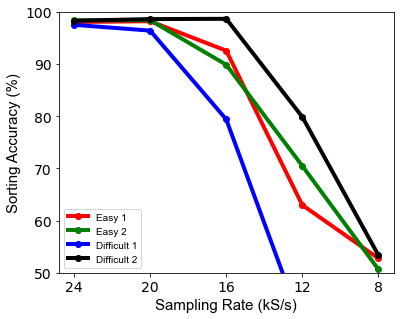

In [36]:
plt.figure(figsize=(6,4.8))
resolutions= [24,20,16,12,8]
titles = ['Easy 1','Easy 2', 'Difficult 1','Difficult 2']

for i in range(len(titles)):
    plt.plot(resolutions,values[:,i]*100,color = 'rgbk'[i],marker='o',markersize=6,linewidth = '4',label=titles[i])
plt.ylim(50,100)
plt.xticks(resolutions,size = 14)
plt.gca().invert_xaxis()
plt.yticks(size = 14)
plt.xlabel('Sampling Rate (kS/s)',fontsize=15,fontname="Arial")
plt.ylabel('Sorting Accuracy (%)',fontsize=15,fontname="Arial")
plt.legend(loc='lower left',prop={'family': 'Arial'})
plt.savefig('RateVSAccuracy.png',dpi=400, transparent=True,bbox_inches = 'tight')
## 16,14,10